## Installs & Imports

In [ ]:
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!python -m pip install nemo_toolkit[all]

exit()

In [ ]:
!pip install jsonlines
!pip install python-Levenshtein

In [1]:
import librosa
import IPython.display as ipd
import glob
import os
import subprocess
import tarfile
import wget
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import json
import pytorch_lightning as pl
from omegaconf import DictConfig
import pandas as pd
from Levenshtein import distance as levenshtein_distance
import jsonlines
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import copy
from omegaconf import DictConfig

In [2]:
import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2021-11-30 15:35:19 optimizers:50] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [3]:
data_dir = '/content'

## Prepare data

Скачаем тренировочные и тестовые данные и модель. В качестве трейна я взяла *train_farfield*, а в качестве теста - тоже *farfield* только из *test*

In [4]:
def load(golos_url, fname):
  if not os.path.exists(os.path.join(data_dir, fname)):
      golos_path = wget.download(golos_url, os.path.join(data_dir, fname))
      print(f"Dataset downloaded at: {golos_path}")
  else:
      print("Tarfile already exists.")
      golos_path = os.path.join(data_dir, fname)
  return golos_path

def load_data(link, data, dir = '/test/'):
    golos_path = load(link, data)

    if not os.path.exists(os.path.join(data_dir, dir)):
        tar = tarfile.open(golos_path)
        tar.extractall(path=data_dir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
load_data("https://sc.link/Kqr", "test.tar", '/test/')
load_data("https://sc.link/1Z3", "train_farfield.tar", '/train_farfield/')

In [ ]:
load("https://sc.link/ZMv", "QuartzNet15x5_golos.nemo")
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

Чтобы освободить место, удалим ненужные файлы

In [8]:
!rm -rf '/content/train_farfield.tar'
!rm -rf '/content/test.tar'
!rm -rf '/content/test/crowd/'

Поправим манифесты и перенесем их, куда надо

In [ ]:
import json

def build_manifest(manifest_rel, manifest_abs):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            for line in fin:
                metadata = json.loads(line)
                if metadata["audio_filepath"].startswith('farfield'):
                    name=os.path.join(data_dir + "/train/", metadata["audio_filepath"])
                    name = name.split('.')
                    name = name[0] + '.wav'
                    metadata["audio_filepath"] = name
                    json.dump(metadata, fout)
                    fout.write('\n')
                elif metadata["audio_filepath"].startswith('files'):
                    metadata["audio_filepath"]=os.path.join(manifest_path, metadata["audio_filepath"])
                    json.dump(metadata, fout)
                    fout.write('\n')
                
print("******")
train_abs = os.path.join(data_dir, 'train/farfield/farfield_train.jsonl')
if not os.path.isfile(train_abs):
  build_manifest("/content/drive/MyDrive/manifest.jsonl", train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)

test_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
test_abs = os.path.join(data_dir, 'test/farfield/farfield_test.jsonl')
if not os.path.isfile(test_abs):
  build_manifest(test_rel, test_abs)
test_manifest = test_abs
print("test_manifest", test_manifest)

******
train_manifest /content/train/farfield/farfield_train.jsonl
test_manifest /content/test/farfield/farfield_test.jsonl


Проверим, сколько у нас файлов для трейна и теста

In [ ]:
len(os.listdir(data_dir + "/test/farfield/files/")), len(os.listdir(data_dir + "/train/farfield/"))

(1916, 124004)

Посмотрим на первые несколько строк манифеста

In [ ]:
!head "/content/train/farfield/farfield_train.jsonl"

{"id": "855e01d6ba9a4aa59950d62037b87709", "audio_filepath": "/content/train/farfield/855e01d6ba9a4aa59950d62037b87709.wav", "text": "\u0430\u0444\u0438\u043d\u0430 \u0445\u043e\u0442\u0435\u043b\u0430 \u043d\u043e\u043c\u0435\u0440 \u0442\u0435\u043b\u0435\u0444\u043e\u043d\u0430 \u043f\u043e\u043c\u0435\u043d\u044f\u0442\u044c \u043a\u0430\u0440\u0442\u044b", "duration": 5.4596875}
{"id": "f6075fae0c592183f107cf781117d9b5", "audio_filepath": "/content/train/farfield/f6075fae0c592183f107cf781117d9b5.wav", "text": "\u0441\u0430\u043b\u044e\u0442 \u0445\u043e\u0447\u0443 \u043f\u043e\u0433\u043e\u0432\u043e\u0440\u0438\u0442\u044c \u0441 \u0434\u0436\u043e\u0439", "duration": 4.15125}
{"id": "2599a6cb55795b38ddd80b849d8670bc", "audio_filepath": "/content/train/farfield/2599a6cb55795b38ddd80b849d8670bc.wav", "text": "\u0434\u0436\u043e\u0439 \u043a\u0430\u043a\u0430\u044f \u0432\u0430\u043b\u044e\u0442\u0430 \u0432 \u043a\u0430\u043c\u0431\u043e\u0434\u0436\u0435", "duration": 3.9185625}

Инициализируем данные в предобученной модели, чтобы затестить ее

In [ ]:
params_model = asr_model._cfg

params_model['train_ds']['parser']='base'
params_model['validation_ds']['parser']='base'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=16
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=16
params_model['test_ds']['manifest_filepath'] = test_manifest
params_model['test_ds']['batch_size']=16

asr_model.setup_training_data(train_data_config=params_model['train_ds'])
asr_model.setup_validation_data(val_data_config=params_model['validation_ds'])
asr_model.setup_test_data(test_data_config=params_model['validation_ds'])

## Test pretrained model

Прежде чем начнем файнтьюнить нашу модель, нужно проверить, какой скор она выдает сейчас

In [ ]:
asr_model.cuda()

wer_nums = []
wer_denoms = []

for test_batch in asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model._wer.compute()
        asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-27 08:20:34 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-27 08:20:35 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

WER = 0.6570031018849917


Получили WER = 0.66

## EDA

Теперь можно поработать с данными, которые будем использовать для файн-тьюнинга. Сначала запишем данные из манифестов в датафреймы

In [ ]:
def get_df(path):
    data = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

train = get_df(train_manifest)
test = get_df(test_manifest)

In [ ]:
train.shape, test.shape

### 1. Пустые файлы

Проверим датасет на пустые строки

In [ ]:
train[train['text'] == '']

,id,audio_filepath,text,duration


In [ ]:
train[train['text'] == ' ']

,id,audio_filepath,text,duration
43160,312a67dd1efccaff55be20c5056cf605,/content/train/farfield/312a67dd1efccaff55be20...,,2.850188
43161,f1028d31a825bbcddca4825c7e5822b7,/content/train/farfield/f1028d31a825bbcddca482...,,7.646312
43162,2ce28f5738e127f0d6c99a24723167a9,/content/train/farfield/2ce28f5738e127f0d6c99a...,,7.410375
43163,3f986a309e5e17d298f2a88888688d46,/content/train/farfield/3f986a309e5e17d298f2a8...,,0.089063
43164,b6ed54a0ae6e9cd3f46d38335b0c68b0,/content/train/farfield/b6ed54a0ae6e9cd3f46d38...,,3.042312
...,...,...,...,...
123871,3a537fc4e0d262eca4192d488616e5e9,/content/train/farfield/3a537fc4e0d262eca4192d...,,2.127375
123881,2ab9de6323ff434caa277500b8062e56,/content/train/farfield/2ab9de6323ff434caa2775...,,9.947250
123882,b2298853166dae47a26214559f81a213,/content/train/farfield/b2298853166dae47a26214...,,4.119250
123967,4174546e8fd483f17cdebc718f495d79,/content/train/farfield/4174546e8fd483f17cdebc...,,2.009500


Уберем их из датасета, а id запишем, чтобы в дальнейшем убрать из манифеста

In [ ]:
id_to_del = train[train['text'] == ' '].id.tolist()

In [ ]:
train = train[train['text'] != ' ']

In [ ]:
train.shape

(116352, 4)

Теперь проверим на продолжительность

In [ ]:
train[train['duration'] <= 1]

,id,audio_filepath,text,duration
104795,d5a2cb0ea44e71d588d19d8642f0f3c4,/content/train/farfield/d5a2cb0ea44e71d588d19d...,салют давай продолжим просмотр видео,0.792125
110012,76f50f42458c0913f93292930873b669,/content/train/farfield/76f50f42458c0913f93292...,алиса поставь таймер на час,0.305125


In [ ]:
example_file = data_dir + '/train/farfield/b9cbb9c2a8b9a4153772f916e1cfac9f.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

Тоже какой-то шум, уберем и это

In [ ]:
id_to_del.extend(train[train['duration'] <= 1].id.tolist())

In [ ]:
train = train[train['duration'] > 1]

In [ ]:
train.shape

(116350, 4)

### 2. Расстояние Левенштейна

Дальше отфильтруем наши данные с помощью расстояния Левенштейна. Сначала оттранскрибируем датасет

In [ ]:
def transcr(path, df):
    prefix = data_dir + path
    files = [prefix + file + '.wav' for file in df.id.tolist()]
    return asr_model.transcribe(paths2audio_files=files)

transcriptions_train = transcr("/train/farfield/", train)
# transcriptions_test = transcr("/test/farfield/files/", test)
train['hypothesis'] = transcriptions_train
# test['hypothesis'] = transcriptions_test

In [ ]:
train

,id,audio_filepath,text,duration,hypothesis
0,855e01d6ba9a4aa59950d62037b87709,/content/train/farfield/855e01d6ba9a4aa59950d6...,афина хотела номер телефона поменять карты,5.459688,афина хотела номер телефона поменять карты
1,f6075fae0c592183f107cf781117d9b5,/content/train/farfield/f6075fae0c592183f107cf...,салют хочу поговорить с джой,4.151250,салют хочу поговорить с джой
2,2599a6cb55795b38ddd80b849d8670bc,/content/train/farfield/2599a6cb55795b38ddd80b...,джой какая валюта в камбодже,3.918563,джой какая валюта вкомпоци
3,5f7483035b2f26b773b0d3fb125b779d,/content/train/farfield/5f7483035b2f26b773b0d3...,салют я могу что нибудь сделать,5.063625,оталют я могу что нибудь сделать
4,4c95a12b71e1262ac937d2fe6a803906,/content/train/farfield/4c95a12b71e1262ac937d2...,джой смотреть операцию ы и другие приключения ...,7.382688,жо и смотрет операцию и и другие приключения ш...
...,...,...,...,...,...
123998,caf1047099be937d61653f52623c910c,/content/train/farfield/caf1047099be937d61653f...,афина какие военные положения в россии ты знаешь,4.114312,афина какие военные положения в россии ты знаешь
123999,dc41f658cc2f3e9efe6d090366cb9682,/content/train/farfield/dc41f658cc2f3e9efe6d09...,джой могут ли соседи вызвать полицию,3.105938,джой могут ли соседи вееать в полицию
124000,47d0acc63fc917d5aac83a3874a70937,/content/train/farfield/47d0acc63fc917d5aac83a...,сбер с каким животным себя,2.986625,опять надо лдеть
124001,b4447dd9fbd5dc3307630fed765f3847,/content/train/farfield/b4447dd9fbd5dc3307630f...,афина какие реквизиты необходимы для проведени...,4.440875,афина какие реквизиты необходемы для проведени...


Теперь посчитаем расстояние

In [ ]:
train['mistakes'] = train.apply(lambda x: 1 if x['text'] != x['hypothesis'] else 0, axis=1)
train['distance'] = train.apply(lambda x: levenshtein_distance(x['text'], x['hypothesis']), axis = 1)

In [ ]:
print(f'Всего: {train.shape}, ошибочных: {train[train['mistakes'] == 1].shape}')
print('\n')
print(f'Процент сэмплов, в которых модель ошиблась {round(train[train["mistakes"] == 1].shape[0]/train.shape[0], 2)} %')

Уберем сэмплы, в которых модель и так не ошибается

In [ ]:
id_to_del.extend(train[train['mistakes'] == 0].id.tolist())

Отсортируем датафрейм по убыванию расстояния и посмотрим, что там происходит

In [ ]:
train[train['mistakes'] == 1].sort_values('distance', ascending=False)

,id,audio_filepath,text,duration,hypothesis,mistakes,distance
1997,dbb941f119e1a6ed6f130d103d29b550,/content/train/farfield/dbb941f119e1a6ed6f130d...,афина сколько будет пятьсот семьдесят четыре п...,7.225000,афнаре,1,103
57423,895ed6b8e3577918c47b4baf3b3a1864,/content/train/farfield/895ed6b8e3577918c47b4b...,джой с чего вдруг на моей карте отрицательный ...,10.893562,олю аани чль батьсетат тлатню еого,1,97
22614,6df0aa327f356e17ab3e8e05d9f51eb0,/content/train/farfield/6df0aa327f356e17ab3e8e...,афина есть ли способ создать свободное поле дл...,10.651563,афина есть ли спусобл афина ва люта бограбеш,1,97
57408,8d3f547402f8d594ad563700403af3a3,/content/train/farfield/8d3f547402f8d594ad5637...,сбер у меня такое настроение прямо сейчас хочу...,10.589375,той а летная партовка у меня такоеродение он ...,1,92
222,a4736bc8a5d9252ff33b6c6ffd8bbecd,/content/train/farfield/a4736bc8a5d9252ff33b6c...,салют почему у всех видео анатолия шария так м...,9.099438,а почему у всех виделол шртнков и,1,91
...,...,...,...,...,...,...,...
71559,2d4f90ed7f0cc31f72806965af3272c5,/content/train/farfield/2d4f90ed7f0cc31f728069...,джой включи изи гайс,2.501313,джой включи изи кайс,1,1
71557,1d0a3e249bfa5a931223a5a8edacacd1,/content/train/farfield/1d0a3e249bfa5a931223a5...,сколько денег у меня на карте два,2.864562,сколько денег у меня на карте дра,1,1
71556,3dc5b652ba910b518cefc0182e99b447,/content/train/farfield/3dc5b652ba910b518cefc0...,включи мелодию будильника на этом телефоне,2.847437,включи мелодию будильник на этом телефоне,1,1
71552,76539746bf339d734661dd92e5f07237,/content/train/farfield/76539746bf339d734661dd...,афина все хватит,2.147250,афиа все хватит,1,1


Построим гистограмму распределения расстояния на ошибочных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38a10bf750>]],
      dtype=object)

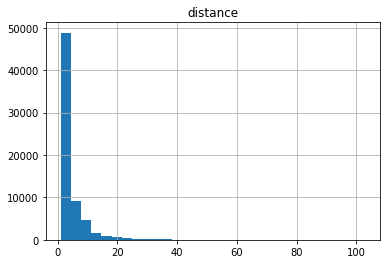

In [ ]:
train[train['mistakes'] == 1].sort_values('distance', ascending=False).hist('distance',bins=30)

In [ ]:
example_file = data_dir + '/train/farfield/a4736bc8a5d9252ff33b6c6ffd8bbecd.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In [ ]:
asr_model.transcribe(paths2audio_files=[data_dir + '/train/farfield/a4736bc8a5d9252ff33b6c6ffd8bbecd.wav'])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-11-27 10:04:06 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


['а почему у всех виделол шртнков и']

Получается, что файлы сами по себе неплохие, просто наша модель не смогла их прочитать. Тогда почему же она так сильно в них ошибается? Если посмотреть на вывод отсортированного датафрейма, то можно заметить, что наверху находятся довольно продолжительные файлы, а внизу относительно короткие. Это значит, что наша модель скорее всего не умеет читать длинные файлы. Для проверки этой гипотезы посмотрим на корреляцию между ошибками и продолжительностью звуковых дорожек

### 3. Продолжительность

Посмотрим, на распределение продолжительности записей отдельно для теста и для трейна. Это нам может показать, что модели и не нужно транскрибировать длинные дорожки, если их нет в тесте

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38a9439d10>]],
      dtype=object)

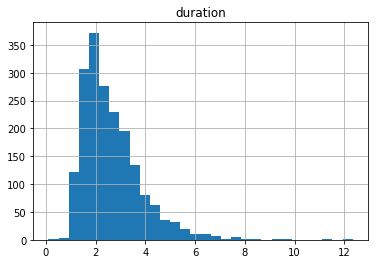

In [ ]:
test.hist('duration',bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38860f5e90>]],
      dtype=object)

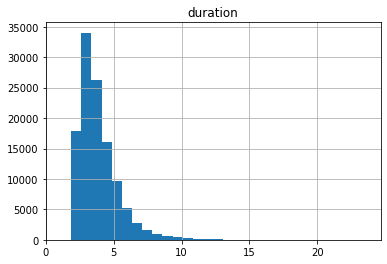

In [ ]:
train.hist('duration',bins=30)

Действительно, в трейне есть файлы гораздо больше тех, что в тесте

А по графику нижу видно, что на продолжительных аудиофайлах модель больше ошибается, чем выдает правильные ответы

[NeMo W 2021-11-27 10:45:53 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
      return array(a, dtype, copy=False, order=order)
    


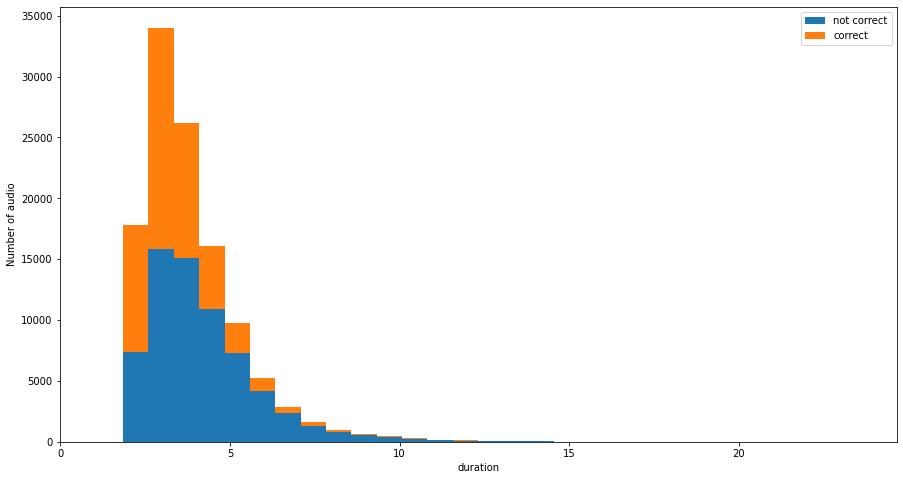

In [ ]:
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['mistakes']==1]['duration'], 
          train[train['mistakes']==0]['duration']], 
         stacked=True, 
         bins=30, 
         label=['not correct','correct'])
plt.xlabel('duration')
plt.ylabel('Number of audio')
plt.legend()

Чтобы разглядеть, что происходит на хвосте, увеличим масштаб и посмотрим только на файлы от 5 секунд

[NeMo W 2021-11-27 10:47:14 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
      return array(a, dtype, copy=False, order=order)
    


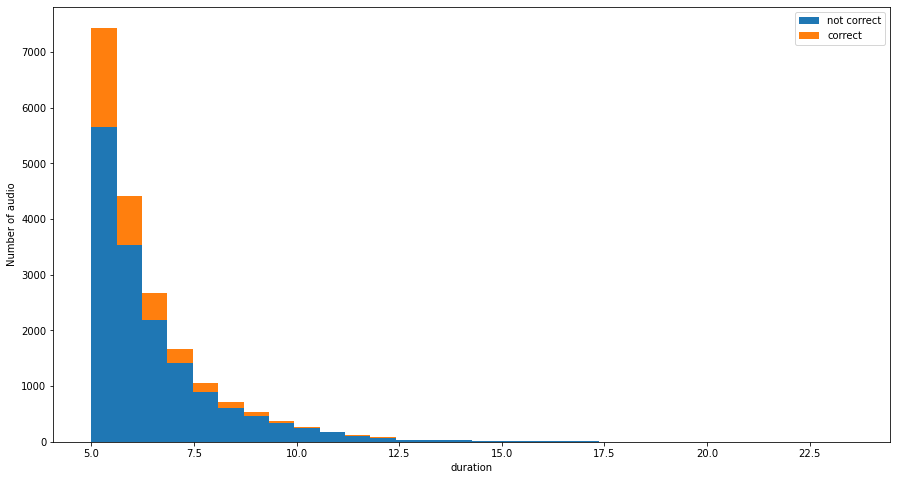

In [ ]:
figure = plt.figure(figsize=(15,8))
sample = train[train['duration'] > 5]
plt.hist([sample[sample['mistakes']==1]['duration'], 
          sample[sample['mistakes']==0]['duration']], 
         stacked=True, 
         bins=30, 
         label=['not correct','correct'])
plt.xlabel('duration')
plt.ylabel('Number of audio')
plt.legend()

И еще посмотрим на корреляцию между расстоянием Левенштейна и продолжительностью. Выходит, что чем длиннее аудиодорожка, тем больше расстояние

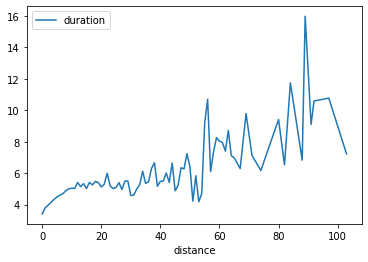

In [ ]:
sample = train[['duration', 'distance']].groupby('distance', as_index=False).mean()
sample.plot('distance', 'duration')

Наша гипотеза подтвердилась, так что можем убрать слишком длинные файлы из нашего датасета, чтобы не путать модель. Я убрала все файлы дольше 6 секунд, потому что по графику распределения продолжительности на тестовой выборке видно, что очень мало сэмплов длины больше 6

In [ ]:
id_to_del.extend(train[train['duration'] > 6].id.tolist())

In [ ]:
id_to_del = list(set(id_to_del))

Проверим, сколько объектов обучающей выборки мы убрали

In [ ]:
len(id_to_del)

64888

Довольно много, около половины. Запишем айдишники ненужных файлов в док, чтобы не потерять

In [ ]:
with open('/content/drive/MyDrive/idx.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(id_to_del))

## Fine-tuning

Теперь можем приступить к файн-тьюнингу! 

Подкачаем айдишники ненужных файлов, инициализируем обучающий минифест без них, инициализируем предобученную модель

In [ ]:
load("https://sc.link/ZMv", "QuartzNet15x5_golos.nemo")
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

In [4]:
with open('/content/drive/MyDrive/idx.txt', encoding='utf-8') as file:
    id_to_del = file.read().split()

Проверка на то, что ничего не потерялось

In [5]:
len(id_to_del)

64888

На случай, если старый манифест, сохранился

In [ ]:
!rm -rf '/content/train/farfield/farfield_train.jsonl'

In [10]:
import json

def build_manifest(manifest_rel, manifest_abs):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            for line in fin:
                metadata = json.loads(line)
                idx = metadata["id"]
                if metadata["audio_filepath"].startswith('farfield') and idx not in id_to_del:
                    name=os.path.join(data_dir + "/train/", metadata["audio_filepath"])
                    name = name.split('.')
                    name = name[0] + '.wav'
                    metadata["audio_filepath"] = name
                    json.dump(metadata, fout)
                    fout.write('\n')
                elif metadata["audio_filepath"].startswith('files'):
                    metadata["audio_filepath"]=os.path.join(manifest_path, metadata["audio_filepath"])
                    json.dump(metadata, fout)
                    fout.write('\n')
                
print("******")
train_abs = os.path.join(data_dir, 'train/farfield/farfield_train.jsonl')
if not os.path.isfile(train_abs):
  build_manifest("/content/drive/MyDrive/manifest.jsonl", train_abs)
train_manifest = train_abs
print("train_manifest", train_manifest)

test_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
test_abs = os.path.join(data_dir, 'test/farfield/farfield_test.jsonl')
if not os.path.isfile(test_abs):
  build_manifest(test_rel, test_abs)
test_manifest = test_abs
print("test_manifest", test_manifest)

******
train_manifest /content/train/farfield/farfield_train.jsonl
test_manifest /content/test/farfield/farfield_test.jsonl


In [6]:
train_manifest = '/content/train/farfield/farfield_train.jsonl'
test_manifest = '/content/test/farfield/farfield_test.jsonl'

In [12]:
!head "/content/test/farfield/farfield_test.jsonl"

{"id": "58b586f67f5e634506e215df5996b82e", "audio_filepath": "/content/test/farfield/files/58b586f67f5e634506e215df5996b82e.wav", "text": "\u0434\u0436\u043e\u0439 \u0445\u0432\u0430\u0442\u0438\u0442", "duration": 1.696625}
{"id": "26093ef7a8c5ec6a3c586a6a929c1bd3", "audio_filepath": "/content/test/farfield/files/26093ef7a8c5ec6a3c586a6a929c1bd3.wav", "text": "\u0441\u0430\u043b\u044e\u0442 \u0432\u044b\u0437\u043e\u0432 \u0441\u0432\u0435\u0442\u043b\u0430\u043d\u0435 \u0432\u0430\u0441\u0438\u043b\u044c\u0435\u0432\u043d\u0435 \u043d\u0438\u043a\u043e\u043b\u0435\u043d\u043a\u043e", "duration": 3.1720625}
{"id": "b42d13ab3dc159fac39a1120e8011f66", "audio_filepath": "/content/test/farfield/files/b42d13ab3dc159fac39a1120e8011f66.wav", "text": "\u0441\u0430\u043b\u044e\u0442 \u0445\u0432\u0430\u0442\u0438\u0442", "duration": 1.5226875}
{"id": "7e55843e745a239b35212e2caba77239", "audio_filepath": "/content/test/farfield/files/7e55843e745a239b35212e2caba77239.wav", "text": "\u0434\u0436\

In [8]:
params_model = asr_model._cfg

new_opt = copy.deepcopy(params_model['optim'])
new_opt['lr'] = 0.0001
asr_model.setup_optimization(optim_config=DictConfig(new_opt))

params_model['train_ds']['parser']='base'
params_model['validation_ds']['parser']='base'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=16
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=16
params_model['test_ds']['manifest_filepath'] = test_manifest
params_model['test_ds']['batch_size']=16

asr_model.setup_training_data(train_data_config=params_model['train_ds'])
asr_model.setup_validation_data(val_data_config=params_model['validation_ds'])
asr_model.setup_test_data(test_data_config=params_model['validation_ds'])

[NeMo W 2021-11-30 13:54:21 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-30 13:54:21 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-30 13:54:21 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2021-11-30 13:54:24 collections:173] Dataset loaded with 59115 files totalling 61.57 hours
[NeMo I 2021-11-30 13:54:24 collections:174] 0 files were filtered totalling 0.00 hours


[NeMo W 2021-11-30 13:54:24 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2021-11-30 13:54:24 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-30 13:54:24 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-30 13:54:24 collections:173] Dataset loaded with 1916 files totalling 1.41 hours
[NeMo I 2021-11-30 13:54:24 collections:174] 0 files were filtered totalling 0.00 hours


In [9]:
asr_model.cuda()

wer_nums = []
wer_denoms = []

for test_batch in asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model._wer.compute()
        asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-30 13:54:28 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-30 13:54:30 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-11-30 13:54:31 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). T

WER = 0.6630875685993797


Проверим, есть ли аугментации. А они уже есть

In [ ]:
print(asr_model._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


Дообучим модель не на всех данных, а на 500 батчах, проверять будем на 5-ти, за 5 эпох. Отслеживать метрики будем с помощью wandb

In [10]:
wandb_logger = WandbLogger(project="ASR")
trainer = Trainer(gpus=1, max_epochs=5, precision=16, logger=wandb_logger, limit_train_batches=500, limit_val_batches=5)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
asr_model.cuda()
trainer.fit(asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-29 16:40:20 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-29 16:40:20 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-29 16:40:20 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-11-29 16:40:40 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-29 16:40:42 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
asr_model.transcribe(paths2audio_files=[data_dir + '/train/farfield/855e01d6ba9a4aa59950d62037b87709.wav'])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-11-29 17:43:25 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


['афина хотела номер телефона поменять карты']

Теперь проверим, какое качество дает дообученная модель

In [ ]:
asr_model.cuda()

wer_nums = []
wer_denoms = []

for test_batch in asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model._wer.compute()
        asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-29 17:43:35 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-29 17:43:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

WER = 0.5288713910761155


Мы добились WER = 0.53, что на 13% превосходит изначальное качество

Теперь на всех данных 1 эпоха

In [ ]:
wandb_logger = WandbLogger(project="ASR")
trainer = Trainer(gpus=1, max_epochs=1, precision=16, logger=wandb_logger, limit_val_batches=5)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
asr_model.cuda()
trainer.fit(asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-30 13:57:19 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-30 13:57:19 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-30 13:57:19 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-11-30 13:57:36 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-30 13:57:38 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
asr_model.save_to('/content/drive/MyDrive/my_model')

In [ ]:
asr_model_test = nemo_asr.models.EncDecCTCModel.restore_from('/content/drive/MyDrive/my_model')

In [15]:
asr_model_test.cuda()

wer_nums = []
wer_denoms = []

for test_batch in asr_model_test.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = asr_model_test(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        asr_model_test._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = asr_model_test._wer.compute()
        asr_model_test._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-30 15:40:57 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-30 15:40:59 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-11-30 15:41:00 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). T

WER = 0.5264853256979242


Здесь получилось 0.526, получше немного. Больше одной эпохи на обучение не хватает мощности. Не хватило даже, чтобы просто потестить, поэтому пришлось сохранять веса модели